In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def load_and_clean_data(filepath):
    print(f"Loading dataset from {filepath}...")
    df = pd.read_csv(filepath)

    if 'id' in df.columns:
        df = df.drop(columns=['id'])

    df = df.dropna(axis=1, how='all')

    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

    if df.isnull().sum().sum() > 0:
        print(f"Imputing {df.isnull().sum().sum()} missing values...")
        df = df.fillna(df.mean())

    X = df.drop(columns=['diagnosis']).values
    y = df['diagnosis'].values
    features = df.drop(columns=['diagnosis']).columns
    return X, y, features

def min_max_normalize(X):
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    denom = max_val - min_val
    denom[denom == 0] = 1.0
    return (X - min_val) / denom

def train_test_split_scratch(X, y, test_size=0.2, seed=42):

    np.random.seed(seed)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split = int(len(X) * (1 - test_size))
    return X[indices[:split]], X[indices[split:]], y[indices[:split]], y[indices[split:]]

X_raw, y, feature_names = load_and_clean_data('data.csv')
X = min_max_normalize(X_raw)
X_train, X_test, y_train, y_test = train_test_split_scratch(X, y, test_size=0.2)

print(f"Task 1 Data Ready: {X_train.shape} Train, {X_test.shape} Test")

Loading dataset from data.csv...
Task 1 Data Ready: (455, 30) Train, (114, 30) Test


In [ ]:
class KNN_Task1:
    def __init__(self, k=3, metric='euclidean', p=3, weights='uniform'):
        """
        k: Neighbors
        metric: 'euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming'
        weights: 'uniform' (Mandatory) or 'distance' (Bonus: Weighted KNN)
        """
        self.k = k
        self.metric = metric
        self.p = p
        self.weights = weights

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def compute_distances(self, X_test):

        if self.metric == 'euclidean':
            return np.sqrt(np.sum((X_test[:, np.newaxis] - self.X_train) ** 2, axis=2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(X_test[:, np.newaxis] - self.X_train), axis=2)
        elif self.metric == 'minkowski':
            return np.power(np.sum(np.power(np.abs(X_test[:, np.newaxis] - self.X_train), self.p), axis=2), 1/self.p)
        elif self.metric == 'cosine':
            X_test_n = X_test / (np.linalg.norm(X_test, axis=1, keepdims=True) + 1e-9)
            X_train_n = self.X_train / (np.linalg.norm(self.X_train, axis=1, keepdims=True) + 1e-9)
            return 1 - np.dot(X_test_n, X_train_n.T)
        elif self.metric == 'hamming':
            return np.mean(X_test[:, np.newaxis] != self.X_train, axis=2)
        return None

    def predict(self, X_test):
        dists = self.compute_distances(X_test)
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            k_indices = np.argsort(dists[i])[:self.k]
            k_labels = self.y_train[k_indices]

            if self.weights == 'uniform':
                # Standard Vote
                y_pred[i] = Counter(k_labels).most_common(1)[0][0]
            else:
                # Weighted Vote
                k_dists = dists[i][k_indices]
                w = 1 / (k_dists + 1e-9)
                votes = {}
                for lbl, weight in zip(k_labels, w):
                    votes[lbl] = votes.get(lbl, 0) + weight
                y_pred[i] = max(votes, key=votes.get)
        return y_pred

--- Running Task 1 Experiments ---

BEST MODEL: K=3, manhattan
Accuracy: 0.9649
Precision: 1.0000, Recall: 0.9149
Confusion Matrix:
 [[67  0]
 [ 4 43]]


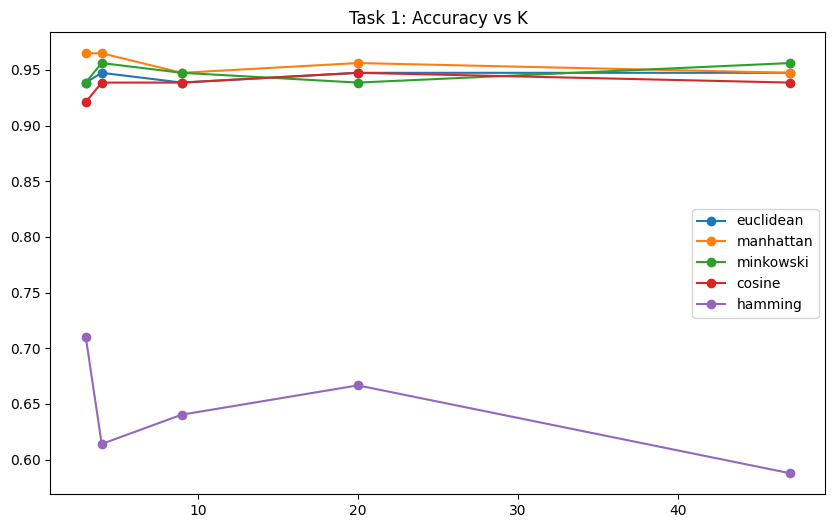

In [ ]:

k_values = [3, 4, 9, 20, 47]
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

results = {}
best_model = {'acc': 0}

print("--- Running Task 1 Experiments ---")
for metric in metrics:
    accs = []
    for k in k_values:
        model = KNN_Task1(k=k, metric=metric)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = np.mean(preds == y_test)
        accs.append(acc)

        if acc > best_model['acc']:
            # Calculate precision/recall for best model
            TP = np.sum((y_test == 1) & (preds == 1))
            FP = np.sum((y_test == 0) & (preds == 1))
            FN = np.sum((y_test == 1) & (preds == 0))
            TN = np.sum((y_test == 0) & (preds == 0))
            best_model = {
                'k': k, 'metric': metric, 'acc': acc,
                'prec': TP/(TP+FP) if (TP+FP)>0 else 0,
                'rec': TP/(TP+FN) if (TP+FN)>0 else 0,
                'cm': np.array([[TN, FP], [FN, TP]])
            }
    results[metric] = accs

# --- Reporting ---
print(f"\nBEST MODEL: K={best_model['k']}, {best_model['metric']}")
print(f"Accuracy: {best_model['acc']:.4f}")
print(f"Precision: {best_model['prec']:.4f}, Recall: {best_model['rec']:.4f}")
print("Confusion Matrix:\n", best_model['cm'])

# Plot
plt.figure(figsize=(10,6))
for m, accs in results.items():
    plt.plot(k_values, accs, marker='o', label=m)
plt.title("Task 1: Accuracy vs K")
plt.legend()
plt.show()

Generating Bonus Decision Boundary...


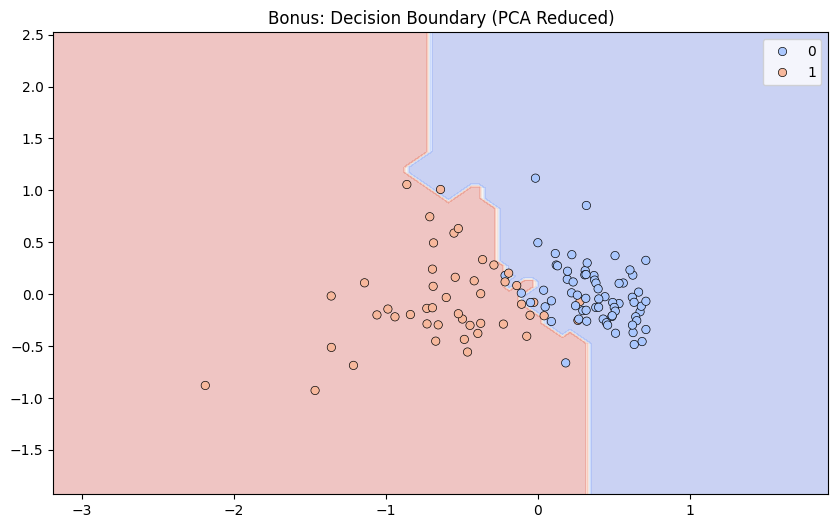

In [ ]:

print("Generating Bonus Decision Boundary...")

# PCA from Scratch
X_c = X - np.mean(X, axis=0)
cov = np.cov(X_c, rowvar=False)
vals, vecs = np.linalg.eigh(cov)
X_pca = np.dot(X_c, vecs[:, ::-1][:, :2])

X_tr_p, X_te_p, y_tr_p, y_te_p = train_test_split_scratch(X_pca, y)
viz_model = KNN_Task1(k=best_model['k'], metric=best_model['metric'])
viz_model.fit(X_tr_p, y_tr_p)

# Plotting
h = 0.05
xx, yy = np.meshgrid(np.arange(X_pca[:,0].min()-1, X_pca[:,0].max()+1, h),
                     np.arange(X_pca[:,1].min()-1, X_pca[:,1].max()+1, h))
Z = viz_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_te_p[:,0], y=X_te_p[:,1], hue=y_te_p, palette='coolwarm', edgecolor='k')
plt.title("Bonus: Decision Boundary (PCA Reduced)")
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10

# Configure plots
sns.set_style("whitegrid")

print("Loading CIFAR-10 Dataset...")
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# Flatten Images: 32x32x3 (3072 dims) -> 1D Array
# Normalization: Scale pixel values from 0-255 to 0-1
X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1).astype('float32') / 255.0
X_test_flat = X_test_full.reshape(X_test_full.shape[0], -1).astype('float32') / 255.0

y_train_flat = y_train_full.flatten()
y_test_flat = y_test_full.flatten()


TRAIN_SIZE = 50000
TEST_SIZE = 500

X_train = X_train_flat[:TRAIN_SIZE]
y_train = y_train_flat[:TRAIN_SIZE]
X_test = X_test_flat[:TEST_SIZE]
y_test = y_test_flat[:TEST_SIZE]

print(f"Original Training Shape: {X_train_full.shape}")
print(f"Subsampled Training Shape: {X_train.shape}")
print(f"Subsampled Testing Shape:  {X_test.shape}")

Loading CIFAR-10 Dataset...
Original Training Shape: (50000, 32, 32, 3)
Subsampled Training Shape: (50000, 3072)
Subsampled Testing Shape:  (500, 3072)


In [ ]:
class KNN_ImageClassifier:
    def __init__(self, k=3, metric='euclidean', p=3):
        """
        k: Number of neighbors
        metric: 'euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming'
        p: Power parameter for Minkowski distance
        """
        self.k = k
        self.metric = metric
        self.p = p

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            # Get the current test image (1D array)
            test_sample = X_test[i]

            if self.metric == 'euclidean':
                # sqrt(sum((x - y)^2))
                # Broadcasting here creates (N_train, Features) -> Safe size (~15MB)
                dists = np.sqrt(np.sum((self.X_train - test_sample) ** 2, axis=1))

            elif self.metric == 'manhattan':
                # sum(|x - y|)
                dists = np.sum(np.abs(self.X_train - test_sample), axis=1)

            elif self.metric == 'minkowski':
                # (sum(|x - y|^p))^(1/p)
                dists = np.power(np.sum(np.power(np.abs(self.X_train - test_sample), self.p), axis=1), 1/self.p)

            elif self.metric == 'cosine':
                # Cosine Distance = 1 - Cosine Similarity
                # Reshape test_sample to (1, Features) for dot product
                ts_reshaped = test_sample.reshape(1, -1)

                # Norms (Compute only once for efficiency if possible, but safe here)
                ts_norm = np.linalg.norm(ts_reshaped) + 1e-9
                tr_norm = np.linalg.norm(self.X_train, axis=1) + 1e-9

                dot_prods = np.dot(self.X_train, ts_reshaped.T).flatten()
                sims = dot_prods / (tr_norm * ts_norm)
                dists = 1 - sims

            elif self.metric == 'hamming':
                # Hamming: Average number of mismatching pixels
                # Note: Strict equality for floats.
                dists = np.mean(self.X_train != test_sample, axis=1)

            else:
                dists = np.zeros(len(self.X_train)) # Fallback

            # --- FIND NEIGHBORS ---
            # Get indices of k nearest neighbors (smallest distances)
            k_indices = np.argsort(dists)[:self.k]
            k_labels = self.y_train[k_indices]

            # Majority Vote
            most_common = Counter(k_labels).most_common(1)
            y_pred[i] = most_common[0][0]

        return y_pred

In [ ]:
# [BLOCK 2.3]
# --- TASK 2: HYPERPARAMETER EXPERIMENTS ---

k_values = [3, 4, 9, 20, 47]
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

results_cifar = {}
best_model_cifar = {'acc': 0}

print(f"Starting Experiments on {len(X_test)} test images...")
print("(This is memory-safe now, but might take ~2-5 minutes depending on CPU)")

for metric in metrics:
    acc_list = []
    print(f"\nProcessing Metric: {metric.upper()}")

    for k in k_values:
        # Initialize & Train
        knn = KNN_ImageClassifier(k=k, metric=metric, p=3)
        knn.fit(X_train, y_train)

        # Predict (Using the Loop-based method)
        preds = knn.predict(X_test)

        # Calculate Accuracy
        acc = np.mean(preds == y_test)
        acc_list.append(acc)
        print(f"  K={k:2} | Accuracy: {acc:.4f}")

        # Save Best Model
        if acc > best_model_cifar['acc']:
            best_model_cifar = {
                'k': k, 'metric': metric, 'acc': acc, 'preds': preds
            }

    results_cifar[metric] = acc_list

# --- RESULTS REPORT ---
print("\n" + "="*40)
print(f"BEST CONFIGURATION (Task 2):")
print(f"K: {best_model_cifar['k']}")
print(f"Metric: {best_model_cifar['metric']}")
print(f"Accuracy: {best_model_cifar['acc']:.4f}")
print("="*40)

# --- PLOT: K vs ACCURACY ---
plt.figure(figsize=(10, 6))
for metric, accs in results_cifar.items():
    plt.plot(k_values, accs, marker='o', label=metric)

plt.title("Task 2: CIFAR-10 Accuracy vs K")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

Starting Experiments on 500 test images...
(This is memory-safe now, but might take ~2-5 minutes depending on CPU)

Processing Metric: EUCLIDEAN
  K= 3 | Accuracy: 0.3500
  K= 4 | Accuracy: 0.3200
  K= 9 | Accuracy: 0.3380
  K=20 | Accuracy: 0.3300
  K=47 | Accuracy: 0.3160

Processing Metric: MANHATTAN
  K= 3 | Accuracy: 0.3600
  K= 4 | Accuracy: 0.3560
  K= 9 | Accuracy: 0.3740
  K=20 | Accuracy: 0.3720
  K=47 | Accuracy: 0.3520

Processing Metric: MINKOWSKI
  K= 3 | Accuracy: 0.3160
  K= 4 | Accuracy: 0.3180
  K= 9 | Accuracy: 0.3080
  K=20 | Accuracy: 0.2880


KeyboardInterrupt: 


BEST CONFIGURATION (Task 2):
K: 9
Metric: manhattan
Accuracy: 0.3740


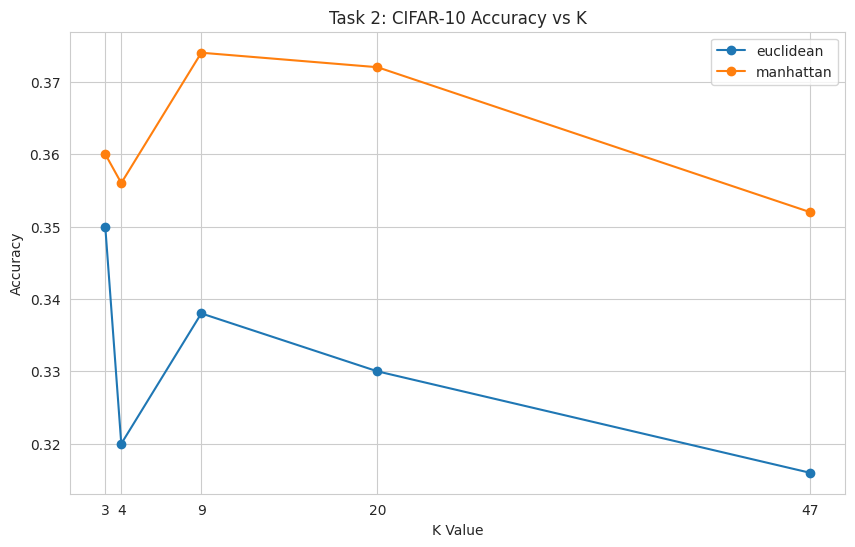

In [ ]:
# --- RESULTS REPORT ---
print("\n" + "="*40)
print(f"BEST CONFIGURATION (Task 2):")
print(f"K: {best_model_cifar['k']}")
print(f"Metric: {best_model_cifar['metric']}")
print(f"Accuracy: {best_model_cifar['acc']:.4f}")
print("="*40)

# --- PLOT: K vs ACCURACY ---
plt.figure(figsize=(10, 6))
for metric, accs in results_cifar.items():
    plt.plot(k_values, accs, marker='o', label=metric)

plt.title("Task 2: CIFAR-10 Accuracy vs K")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

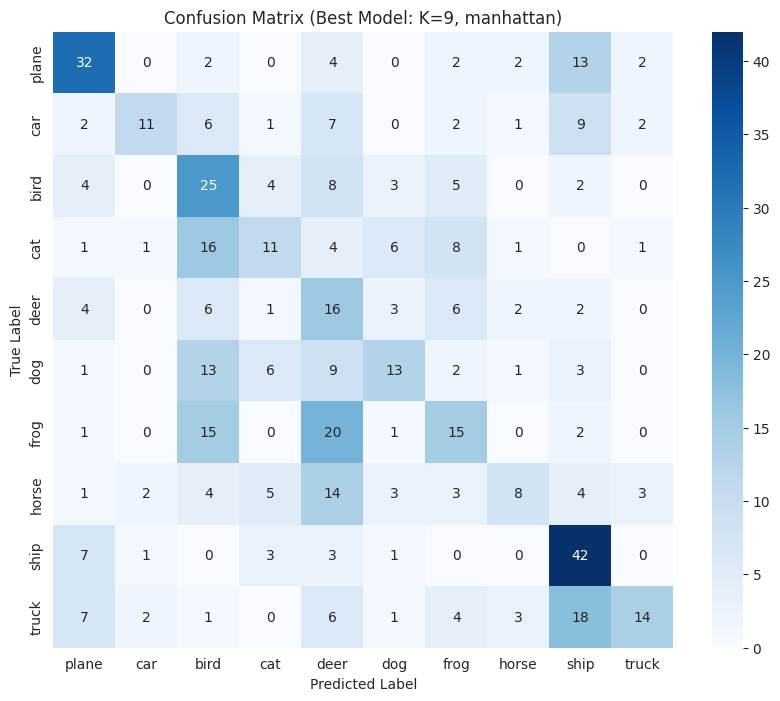


--- PER-CLASS PERFORMANCE ---
Class      | Precision  | Recall    
------------------------------------
plane      | 0.53       | 0.56      
car        | 0.65       | 0.27      
bird       | 0.28       | 0.49      
cat        | 0.35       | 0.22      
deer       | 0.18       | 0.40      
dog        | 0.42       | 0.27      
frog       | 0.32       | 0.28      
horse      | 0.44       | 0.17      
ship       | 0.44       | 0.74      
truck      | 0.64       | 0.25      

--- VISUALIZING ERROR SAMPLES ---


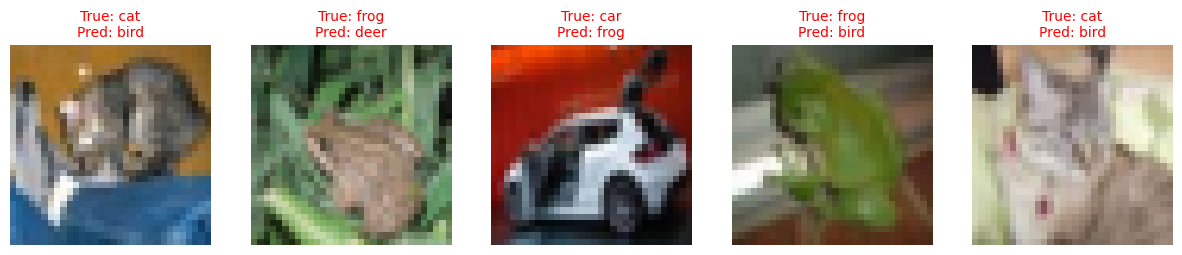

In [ ]:
from sklearn.metrics import confusion_matrix

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
best_preds = best_model_cifar['preds']

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, best_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title(f"Confusion Matrix (Best Model: K={best_model_cifar['k']}, {best_model_cifar['metric']})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 2. Per-Class Precision & Recall
# Calculating manually "from scratch" logic (using the CM we just built)
print("\n--- PER-CLASS PERFORMANCE ---")
print(f"{'Class':<10} | {'Precision':<10} | {'Recall':<10}")
print("-" * 36)

for i, class_name in enumerate(classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP

    prec = TP / (TP + FP) if (TP+FP) > 0 else 0
    rec = TP / (TP + FN) if (TP+FN) > 0 else 0
    print(f"{class_name:<10} | {prec:<10.2f} | {rec:<10.2f}")

print("\n--- VISUALIZING ERROR SAMPLES ---")
errors = np.where(best_preds != y_test)[0]
num_errors_to_show = 5

plt.figure(figsize=(15, 3))
for i, idx in enumerate(errors[:num_errors_to_show]):
    plt.subplot(1, num_errors_to_show, i+1)
    # Reshape back to image format (32, 32, 3)
    img = X_test[idx].reshape(32, 32, 3)
    plt.imshow(img)

    true_lbl = classes[y_test[idx]]
    pred_lbl = classes[int(best_preds[idx])]

    plt.title(f"True: {true_lbl}\nPred: {pred_lbl}", color='red', fontsize=10)
    plt.axis('off')
plt.show()